In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from src.datareader import datareader as dr

<h3>Initialize Data Readers</h3>

In [2]:
# ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
# era5_data_reader = dr.getDataReader(datasource='ERA5', filename="1959-2022-6h-1440x721.zarr/") # <-- 6hr, high resolution data

ufs_data_reader = dr.getDataReader(datasource='UFS', model='atm')
era5_data_reader = dr.getDataReader(datasource='ERA5') # <-- 6hr, lower-resolution data by default

No filename provided; deferring to default
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset read.
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr/
ERA5 dataset loaded.
Standardizing coordinate system
Sorting lat descending
Dataset read.


<h3>Describe</h3>

In [3]:
ufs_data_reader.describe('uprs')
#ufs_data_reader.describe()


Variable: uprs
Dimensions: ('init', 'member', 'lead', 'lev', 'lat', 'lon')
Shape: (60, 11, 4, 39, 192, 384)
Attributes:
  - long_name: U component of wind
  - units: m s**-1


In [4]:
era5_data_reader.describe('u_component_of_wind')
#era5_data_reader.describe()


Variable: u_component_of_wind
Dimensions: ('time', 'lat', 'lon', 'lev')
Shape: (92044, 256, 512, 13)
Attributes:
  - long_name: U component of wind
  - short_name: u
  - standard_name: eastward_wind
  - units: m s**-1


In [8]:
#ufs_data_reader.dataset

In [9]:
#era5_data_reader.dataset

<h3>Retrieve DataSets</h3>

In [10]:
time_range = ("1994-05-01","2021-05-31T23")

In [11]:
# Retrieve a UFS dataset
# The complete dataset is preserved after retrieval
ufs_ds = ufs_data_reader.retrieve(
    var=["tmp2m", "uprs", "vprs"],
    #var = 'tmp2m',
    #lat=(30, 50),
    #lon=(240, 280),
    lev=500,
    time=time_range,
    ens_avg=True
) 

Slicing by init
Slicing by model dimension lev
Taking Ensemble Average


In [12]:
ufs_ds

<xarray.Dataset> Size: 195MB
Dimensions:  (init: 55, lead: 4, lat: 192, lon: 384)
Coordinates:
  * init     (init) datetime64[ns] 440B 1994-05-01 1994-11-01 ... 2021-05-01
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * lead     (lead) int64 32B 0 1 2 3
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
Data variables:
    tmp2m    (init, lead, lat, lon) float32 65MB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    uprs     (init, lead, lat, lon) float32 65MB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    vprs     (init, lead, lat, lon) float32 65MB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    history:                 2024-12-09T11:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             US National Weather Service - NCEP

In [13]:
# Retrieve an ERA5 dataset 
# The complete dataset is preserved after retrieval
era5_ds = era5_data_reader.retrieve(
    var=['2m_temperature', 'u_component_of_wind', 'v_component_of_wind'],
    #lat=(30, 50),
    #lon=(240, 280),
    lev=500,
    time=time_range
)

Slicing by time
Slicing by lev


In [14]:
era5_ds

<xarray.Dataset> Size: 62GB
Dimensions:              (time: 39572, lat: 256, lon: 512)
Coordinates:
  * lat                  (lat) float64 2kB 89.65 88.95 88.24 ... -88.95 -89.65
  * lon                  (lon) float64 4kB 0.0 0.7031 1.406 ... 358.6 359.3
  * time                 (time) datetime64[ns] 317kB 1994-05-01 ... 2021-05-3...
Data variables:
    2m_temperature       (time, lat, lon) float32 21GB dask.array<chunksize=(124, 256, 512), meta=np.ndarray>
    u_component_of_wind  (time, lat, lon) float32 21GB dask.array<chunksize=(124, 256, 512), meta=np.ndarray>
    v_component_of_wind  (time, lat, lon) float32 21GB dask.array<chunksize=(124, 256, 512), meta=np.ndarray>

<h1>Regrid</h1>

In [15]:
from src.regridder import Regrid

<h3>Initialize Regridder</h3>

In [16]:
regridder = Regrid.Regrid(data_reader1=ufs_data_reader,
                          data_reader2=era5_data_reader,
                          method='bilinear')

Verification grid set to data_reader2
Initializing Regridder with method 'bilinear'
Regridder initialized.


<h3>Test Cases:</h3>

In [14]:
# CASE 1:  ONE WIND VECTOR INCLUDED BUT NOT THE OTHER
# INTENDED BEHAVIOR:  ERROR with custom message.  You must supply the other wind vector.

# aligned = regridder.align(
#     var=['v_component_of_wind'],
#     time=time_range)

In [15]:
# CASE 2:  WIND VECTORS INCLUDED BUT NOT ON A GLOBAL DOMAIN
# INTENDED BEHAVIOR:  ERROR WITH CUSTOM MESSAGE

# aligned = regridder.align(
#     var=['u_component_of_wind', 'v_component_of_wind'],
#     lat=(30, 50),
#     lon=(240, 280),
#     lev=500,
#     time=time_range)

In [16]:
# CASE 3:  No var specified
# INTENDED BEHAVIOR:  ERROR WITH CUSTOM MESSAGE

# aligned = regridder.align(
#     var=None,
#     time=time_range)

In [17]:
# CASE 4:  BOTH SCALAR AND WIND VECTORS INCLUDED
# INTENDED BEHAVIOR:  ERROR with custom message.  You can only submit 1 scalar variable or 2 wind vectors.

# aligned = regridder.align(
#     var=['2m_temperature', 'u_component_of_wind', 'v_component_of_wind'],
#     lev=500,
#     time=time_range)

In [18]:
# CASE 5:  ONE SCALAR AND ONE WIND VECTOR INCLUDED
# INTENDED BEHAVIOR:  ERROR with custom message.  You submitted one wind vector but not the other.

# aligned = regridder.align(
#     var=['2m_temperature', 'u_component_of_wind'],
#     lev=500,
#     time=time_range)

In [19]:
# CASE 6:  EMPTY VAR LIST provided
# INTENDED BEHAVIOR:  ERROR with custom message.  You submitted empty list.

# aligned = regridder.align(
#     var=[],
#     lev=500,
#     time=time_range)

In [20]:
# CASE 7:  MULTIPLE SCALARS PROVIDED
# INTENDED BEHAVIOR:  ERROR with custom message.  Multiple variables provided but none are wind vectors.

# aligned = regridder.align(
#     var=['2m_temperature', 'specific_humidity'],
#     lev=500,
#     time=time_range)

In [21]:
# CASE 8:  LEV FOR FLAT VARIABLE
# INTENDED BEHAVIOR:  ERROR with custom message.  This var doesn't have lev.

# aligned = regridder.align(
#     var='2m_temperature',
#     lev=500,
#     time=time_range)

In [22]:
# CASE 9:  DID NOT SPECIFY LEV
# INTENDED BEHAVIOR:  ERROR with custom message.  You must specify a lev.

# aligned = regridder.align(
#     var= ['u_component_of_wind', 'v_component_of_wind'],
#     #lev=500,
#     time=time_range)

In [17]:
# CASE 10:  ONLY SCALAR VARIABLES INCLUDED
# INTENDED BEHAVIOR:  RUN SUCCESSFULLY

aligned = regridder.align(
    var='2m_temperature', #, 'specific_humidity'],
    time=time_range)


DEBUG: Starting alignment process
Slicing by time
Slicing by init
auto_resample set to True
DEBUG: Interpreting lead as monthly intervals
DEBUG: Resampling verification data to 'MS' using mean aggregation.
Number of cores available: 2
Concatenating resample results
Resampling done in 1.7050946474075317 minutes.
Running scalar regrid on 2m_temperature
Completed scalar regrid in 0.01546837091445923 minutes.
DEBUG: Auto-selected tolerance = 16 days

DEBUG: Alignment complete — matched=217, filled with NaNs=3
DEBUG: Alignment complete.
Standardizing coordinate system
Dataset read.


In [26]:
# CASE 11:  ONLY WIND VECTORS INCLUDED
# INTENDED BEHAVIOR:  RUN SUCCESSFULLY

aligned = regridder.align(
    var= ['u_component_of_wind', 'v_component_of_wind'],
    lev=500,
    time=time_range)


DEBUG: Starting alignment process
Slicing by time
Slicing by lev
Slicing by init
auto_resample set to True
DEBUG: Interpreting lead as monthly intervals
DEBUG: Resampling verification data to 'MS' using mean aggregation.
Number of cores available: 2
Concatenating resample results
Resampling done in 19.598450688521066 minutes.
Running spherical harmonics on u_component_of_wind and v_component_of_wind
Completed sperical harmonics in 0.6509894371032715 minutes.
DEBUG: Auto-selected tolerance = 16 days

DEBUG: Alignment complete — matched=217, filled with NaNs=3
DEBUG: Alignment complete.
Standardizing coordinate system
Dataset read.


<h1>Sanity Check</h1>

In [27]:
aligned.describe()

,Variable,Dimensions,Shape,Description,Units
0,u_component_of_wind,"lead, init, lat, lon",4 × 55 × 192 × 384,-,-
1,v_component_of_wind,"lead, init, lat, lon",4 × 55 × 192 × 384,-,-


In [28]:
aligned.dataset

<xarray.Dataset> Size: 130MB
Dimensions:              (lead: 4, init: 55, lat: 192, lon: 384)
Coordinates:
    time                 (init, lead) datetime64[ns] 2kB 1994-05-01 ... 1994-...
  * lat                  (lat) float64 2kB 89.28 88.36 87.42 ... -88.36 -89.28
  * lon                  (lon) float64 3kB 0.0 0.9375 1.875 ... 358.1 359.1
  * init                 (init) datetime64[ns] 440B 1994-05-01 ... 2021-05-01
  * lead                 (lead) int64 32B 0 1 2 3
Data variables:
    u_component_of_wind  (lead, init, lat, lon) float32 65MB -2.002 ... nan
    v_component_of_wind  (lead, init, lat, lon) float32 65MB -3.878 ... nan
Attributes:
    regrid_method:        bilinear
    model_freq_unit:      MS
    lead_step:            30 days
    alignment_tolerance:  16 days

In [29]:
list(aligned.dataset.time.values)[0:3]

[array(['1994-05-01T00:00:00.000000000', '1994-06-01T00:00:00.000000000',
        '1994-07-01T00:00:00.000000000', '1994-08-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array(['1994-11-01T00:00:00.000000000', '1994-12-01T00:00:00.000000000',
        '1995-01-01T00:00:00.000000000', '1995-02-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array(['1995-05-01T00:00:00.000000000', '1995-06-01T00:00:00.000000000',
        '1995-07-01T00:00:00.000000000', '1995-08-01T00:00:00.000000000'],
       dtype='datetime64[ns]')]

<h3>Run these cells if you regridded 2m_temperature</h3>

In [21]:
def plot_robinson(dataslice, title):

    projection = ccrs.Robinson()
    crs = ccrs.PlateCarree()
    
    plt.figure(figsize=(14,7), dpi=100)
    ax = plt.axes(projection=projection)
    ax.set_global()
    dataslice.plot(ax=ax, transform=crs) #, vmin=200, vmax=320)
    ax.coastlines()
    
    if 'time' in list(dataslice.coords):
        title = f"{title} TIME {str(dataslice.time.values)}"
        
    elif 'init' in list(dataslice.coords):
        title = f"{title} INIT {str(dataslice.init.values)}"
        
    plt.title(f"{title}")
    
    return plt

<module 'matplotlib.pyplot' from '/home/thamzey/.conda/envs/ufs_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

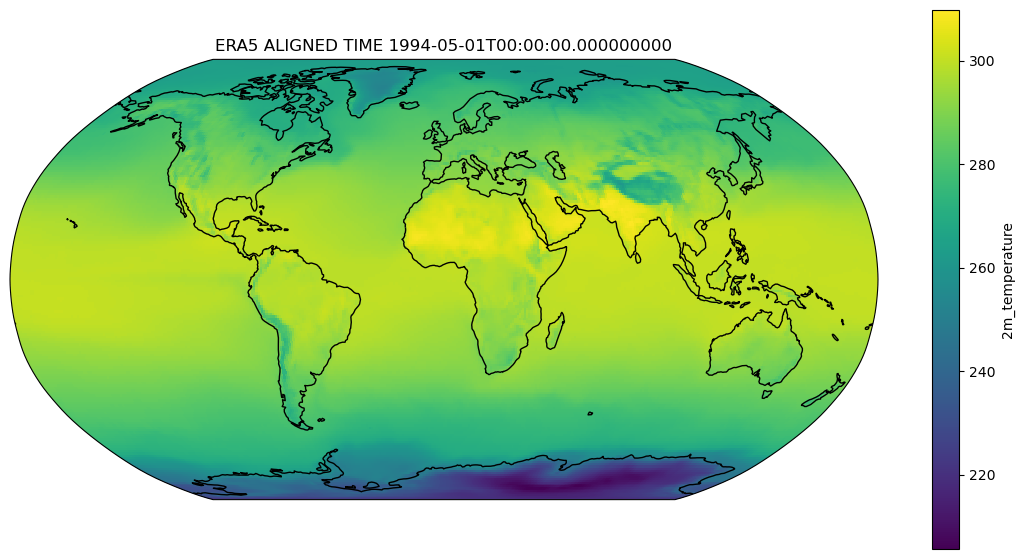

In [22]:
dataslice = aligned.dataset.isel(init=0, lead=0)['2m_temperature']
plot_robinson(dataslice, 'ERA5 ALIGNED')

<module 'matplotlib.pyplot' from '/home/thamzey/.conda/envs/ufs_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

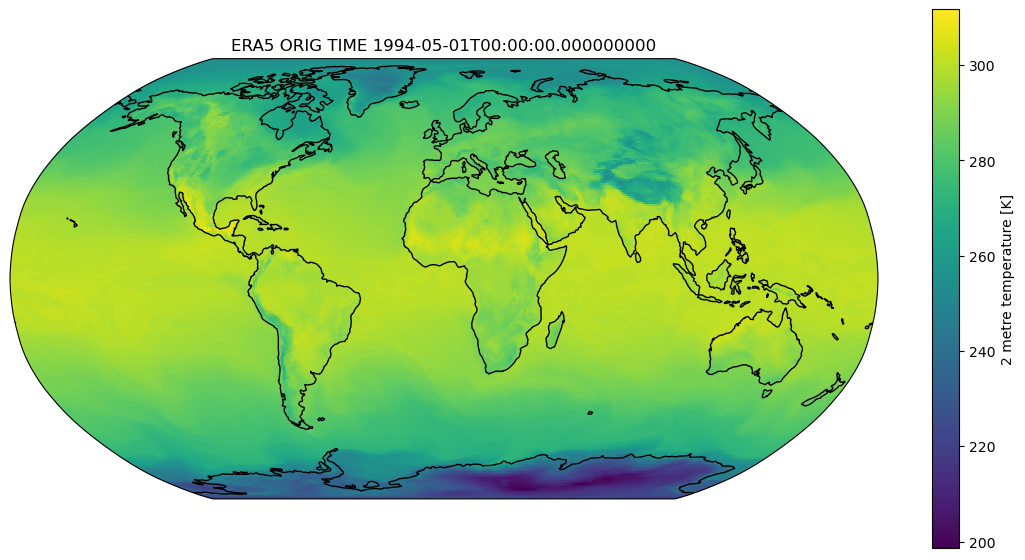

In [23]:
dataslice = era5_ds.isel(time=0)['2m_temperature'] # <-- This isn't a monthly mean, just one time step
plot_robinson(dataslice, 'ERA5 ORIG')

<module 'matplotlib.pyplot' from '/home/thamzey/.conda/envs/ufs_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

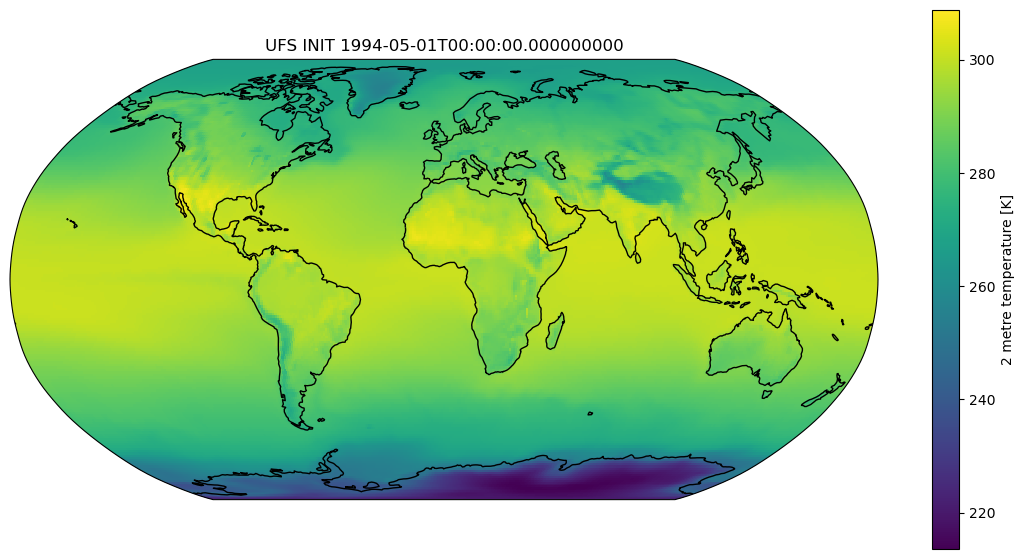

In [24]:
dataslice = ufs_ds.isel(init=0, lead=0)['tmp2m']
plot_robinson(dataslice, 'UFS')

<module 'matplotlib.pyplot' from '/home/thamzey/.conda/envs/ufs_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

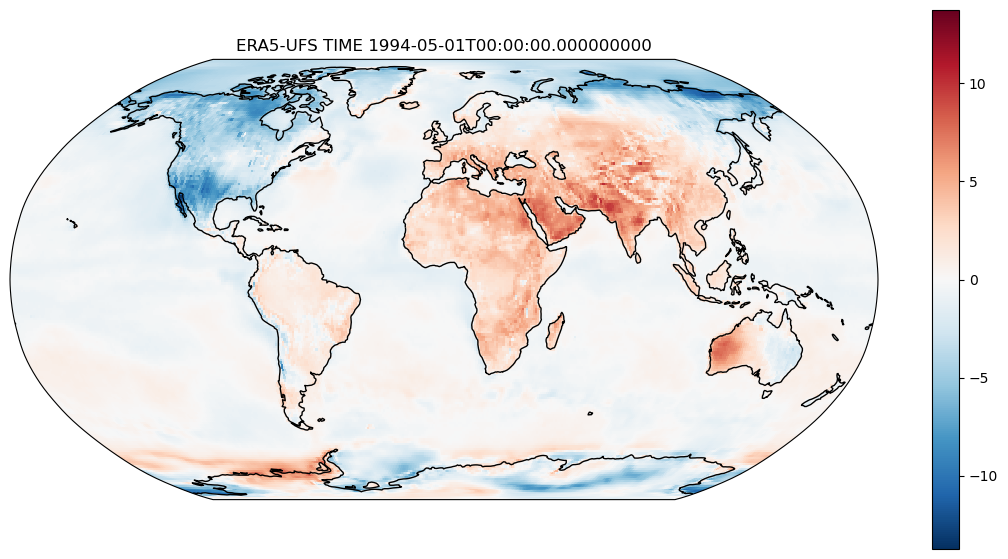

In [25]:
dataslice = aligned.dataset.isel(init=0, lead=0)['2m_temperature'] - ufs_ds.isel(init=0, lead=0)['tmp2m'] # <-- Monthly means
plot_robinson(dataslice, 'ERA5-UFS')

<h3>Run these cells if you regridded u-v</h3>

In [30]:
dataslice = aligned.dataset.isel(init=0, lead=0)

In [31]:
dataslice = dataslice.assign(verif_magnitude=(('lat', 'lon'), np.sqrt(dataslice['u_component_of_wind'].values**2 + dataslice['v_component_of_wind'].values**2)))

In [32]:
latmin = -30.0
latmax = 0.0
lonmin = 300.0
lonmax = 345.0

In [33]:
region = dataslice.where(aligned.dataset.lat >= latmin, drop=True)
region = region.where(region.lat <= latmax, drop=True)
region = region.where(region.lon >= lonmin, drop=True)
region = region.where(region.lon <= lonmax, drop=True)

Text(0.5, 1.0, 'ERA5 Regrid')

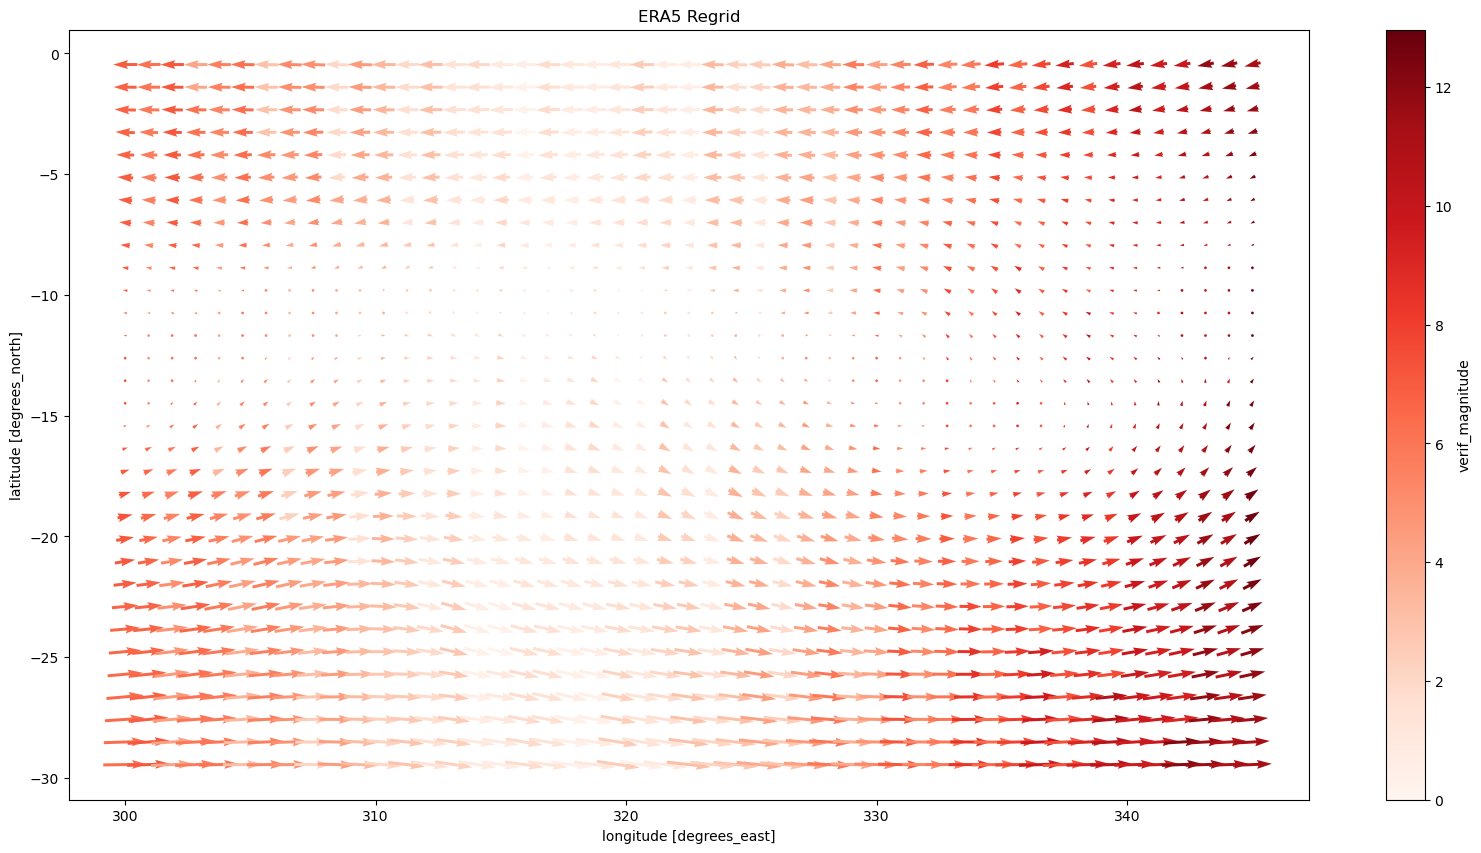

In [34]:
ax = region.plot.quiver(x='lon', y='lat', u='u_component_of_wind', v='v_component_of_wind',
                        hue='verif_magnitude', cmap='Reds', vmin=0, #vmax = maxspeed,
                        size=10, aspect=2)

plt.title("ERA5 Regrid")

In [35]:
dataslice = era5_ds[['u_component_of_wind', 'v_component_of_wind']].isel(time=0)  # <-- This is just one timestep of the original ERA5 dataset

In [36]:
dataslice = dataslice.assign(verif_magnitude=(('lat', 'lon'), np.sqrt(dataslice['u_component_of_wind'].values**2 + dataslice['v_component_of_wind'].values**2)))

In [37]:
region = dataslice.where(dataslice.lat >= latmin, drop=True)
region = region.where(region.lat <= latmax, drop=True)
region = region.where(region.lon >= lonmin, drop=True)
region = region.where(region.lon <= lonmax, drop=True)

Text(0.5, 1.0, 'ERA5 Original')

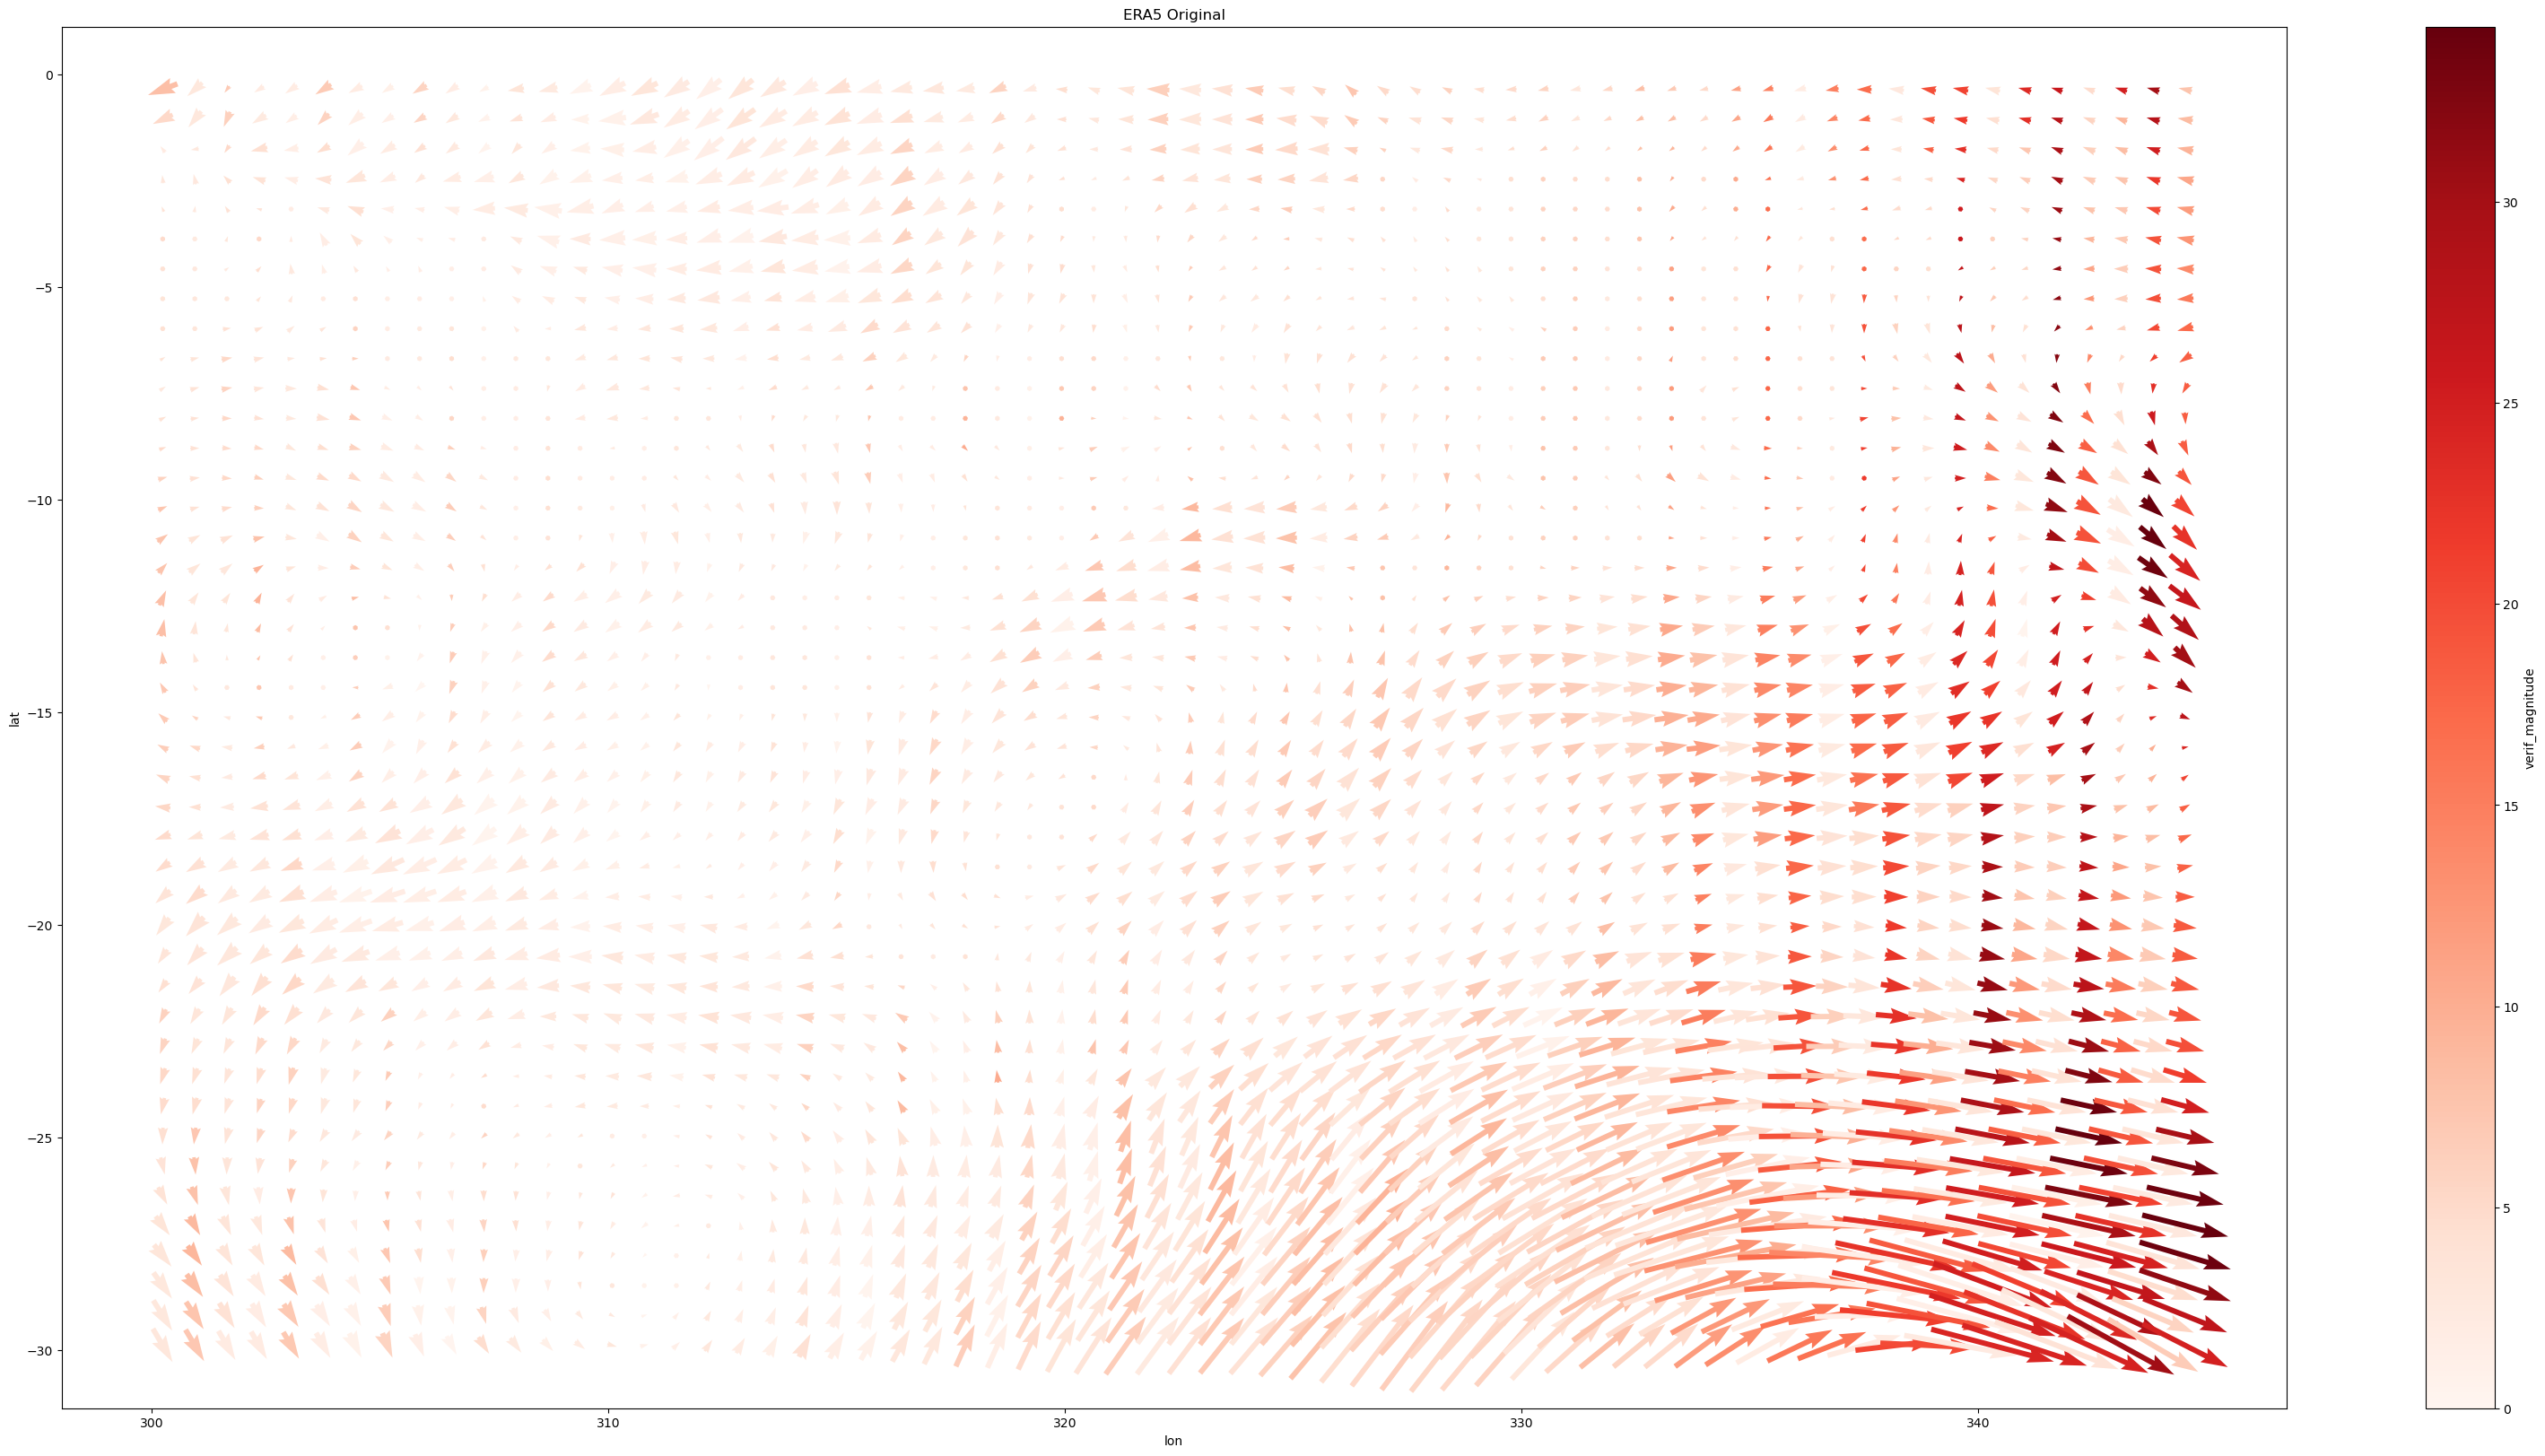

In [38]:
ax = region.plot.quiver(x='lon', y='lat', u='u_component_of_wind', v='v_component_of_wind',
                        hue='verif_magnitude', cmap='Reds', vmin=0, #vmax = maxspeed,
                        size=20, aspect=2)

plt.title("ERA5 Original")